In [6]:
import sys
import os
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid
import itertools
import pdb
from scipy.optimize import curve_fit
from copy import copy, deepcopy

sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
from SPAM import *

sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation")
import EAB_process_modified 
from EAB_CB_data_analysis import *

In [7]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

In [8]:
path2file="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/FTXX45middleionidle_03052024_45213/results/7f114074-03ef-478b-be3b-caf3499299f8FTXX45_EAB_middleionidle_01+10_45213_03052024_ExperimentalData"
with open(path2file, "rb") as fp:
    eab_load_cpy=pickle.load(fp)

In [9]:
'''Specify a set of Pauli you want to estimate'''

C=20
nqubit=2
depth=[2,8,16,32]
shots=2000
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = nqubit)] #full
eab_result=EAB_process_modified.process_EAB_01(depth, eab_load_cpy, pauli_request_list)
# print (eab_result)


Analyze full set of data without bootstrapping

Parameters: n = 2, C = 20,  L =  [2, 8, 16, 32]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.023273813627056605
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.0165195 0.0011627
YI 0.0229757 0.0013811
ZI 0.0197205 0.0008178
IX 0.0211026 0.0009275
XX 0.0325033 0.0015322
YX 0.0306273 0.0014754
ZX 0.0293662 0.001319
IY 0.0251212 0.0010396
XY 0.0282581 0.0013655
YY 0.0394162 0.0018065
ZY 0.0305307 0.0012248
IZ 0.0167241 0.0006878
XZ 0.0223109 0.0012805
YZ 0.0247081 0.0014102
ZZ 0.0124965 0.0007179

Label / Pauli error rates
II 0.9767262
XI 0.0029563
YI 0.0006894
ZI 0.0038911
IX 0.0016719
XX 0.0011142
YX 0.0022361
ZX 0.0001635
IY 0.0004561
XY 0.0023867
YY 0.0002501
ZY 8.36e-05
IZ 0.0063419
XZ 8.7e-05
YZ 0.0001405
ZZ 0.0008056


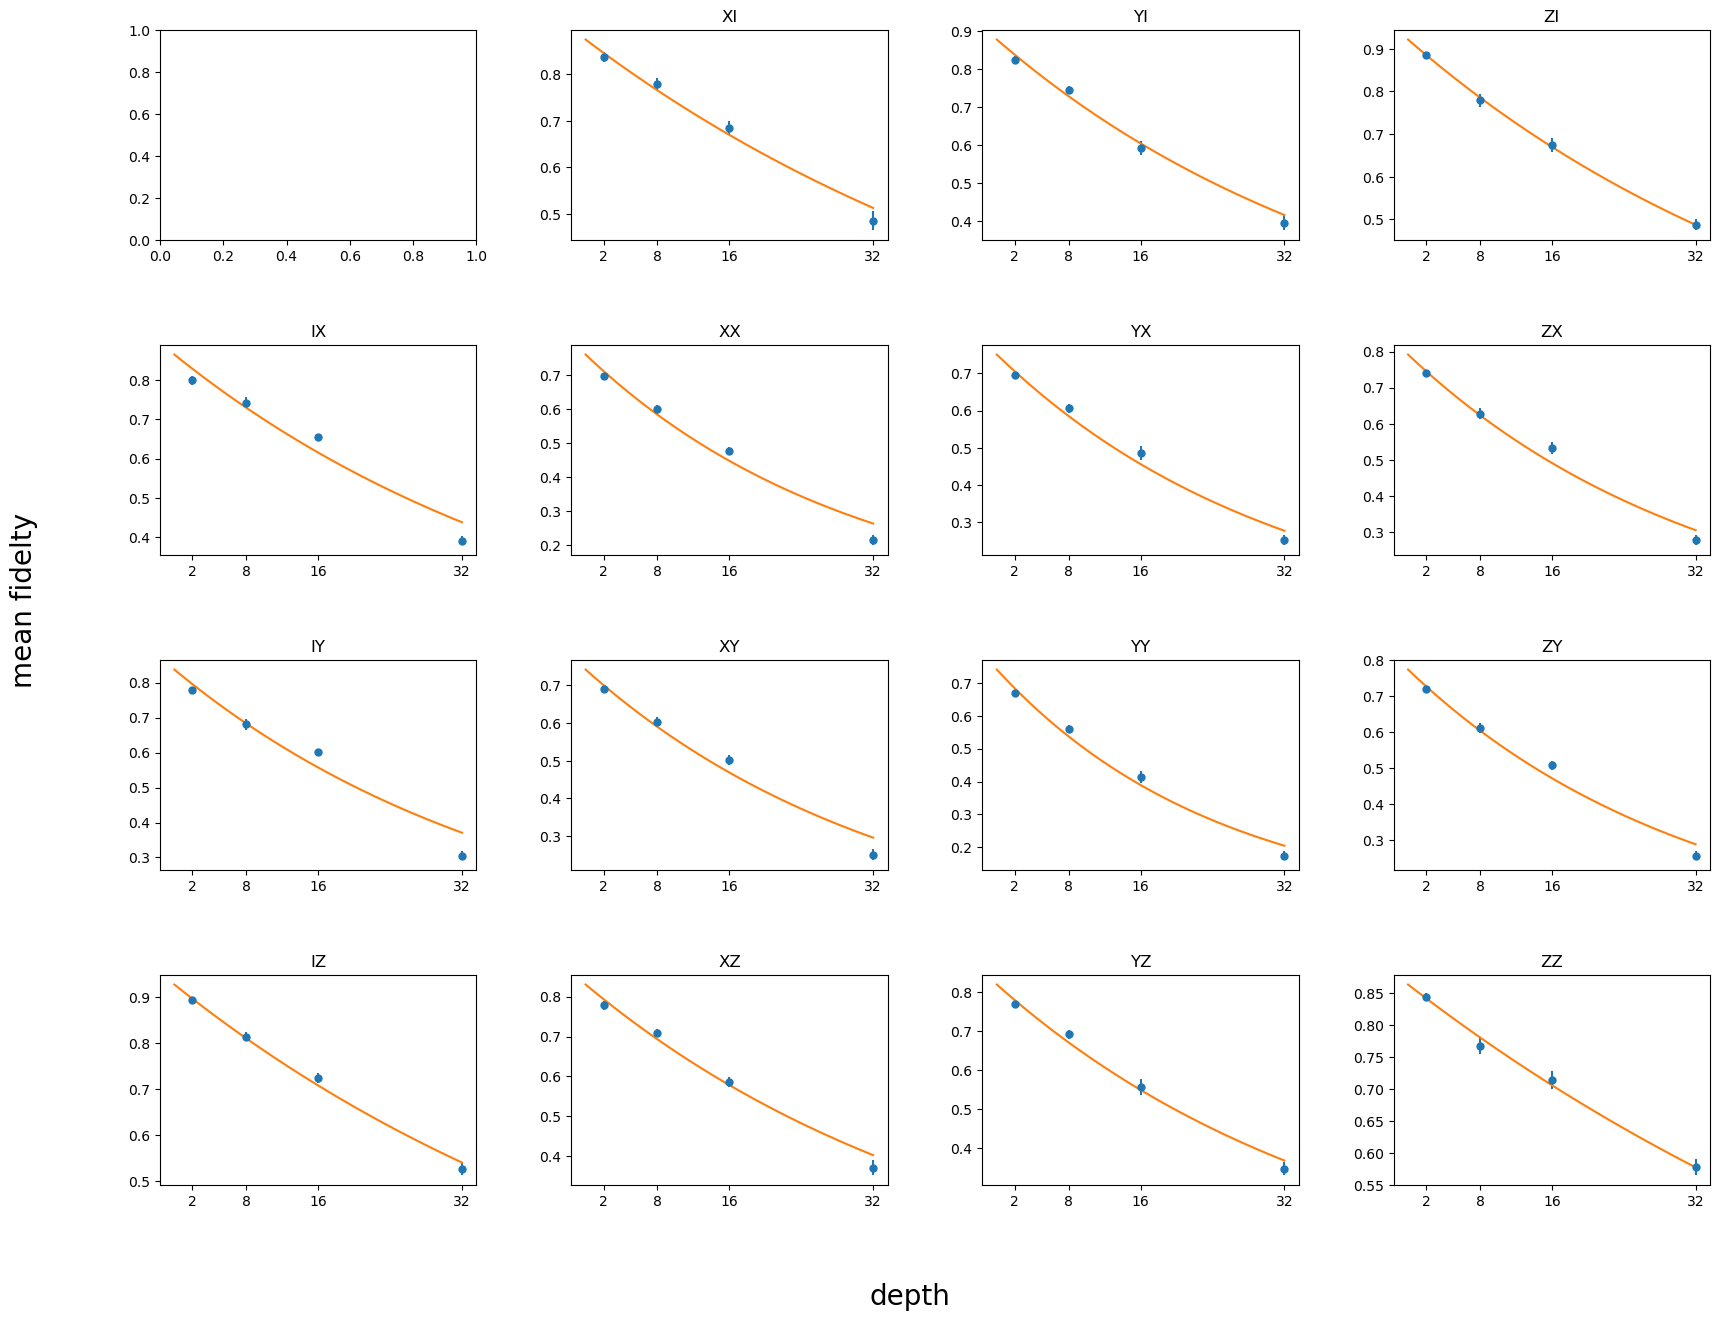

In [10]:
raw_fidelity_list = eab_result["fidelity_list"]
plot_dic={}
error_dic={}
fidelity_list = {}
stdev_list = {}
a_full_dic={}
Y_full_dic={}
Yerr_full_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha,a, alpha_err,Y, Yerr = fit_EAB_plot(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha #pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err #error on pauli fidelity from fit
        a_full_dic[pauli_label]=a 
        Y_full_dic[pauli_label]=Y
        Yerr_full_dic[pauli_label]=Yerr

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
# shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(1-fidelity_list[pauli_label],7), round(stdev_list[pauli_label],7))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]

error_list = fidelity_to_error(fidelity_list,nqubit)
print("\nLabel / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(error_list[pauli_label],7))


plot_full={}
plot_full=deepcopy(plot_dic)
err_full=deepcopy(error_dic)
# print (Y_full_dic)

x_c=np.linspace(0,32,num=80)
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (4):
    for j in range(4):
        pauli_label=pauli_request_list[4*i+j]
        if (pauli_label == 'I'*nqubit):
            pass
        else:
            axs[i, j].set_xticks(depth)   
            axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=5)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
                


scatter plot: result from each circuit

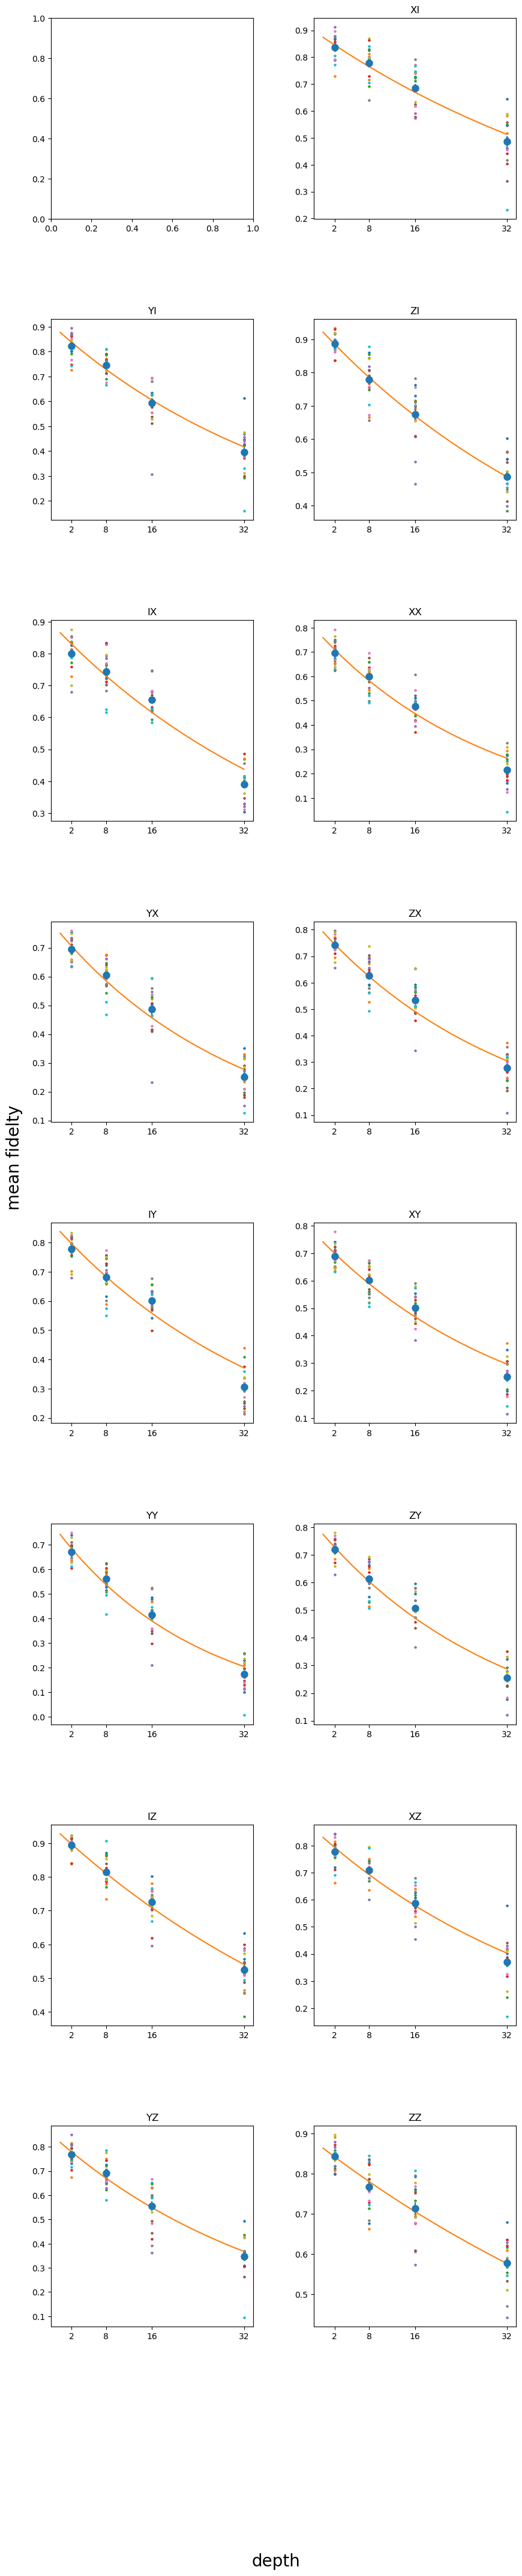

In [11]:
x_c=np.linspace(0,32,num=80)
# nqubit=2
fig, axs = plt.subplots(8, 2)
fig.set_figwidth(10)
fig.set_figheight(50)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (8):
    for j in range(2):
        pauli_label=pauli_request_list[2*i+j]
        if (pauli_label == 'I'*nqubit):
#                 fidelity_list[pauli_label] = 1.0
#                 stdev_list[pauli_label] = 0.0
            pass
        else:
            axs[i, j].set_xticks(depth)   
#             print ([tuple(eab_result['fidelity_list'][pauli_label][2])])
            axs[i, j].plot(depth,[tuple(eab_result['fidelity_list'][pauli_label][L]) for L in depth],"*",markersize=3)
            axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=8)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
                
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)        

# data analysis with bootstrapping

full set of data with bootstrapping

In [13]:
import seaborn as sns
pal=sns.color_palette("colorblind",10)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (16,) + inhomogeneous part.

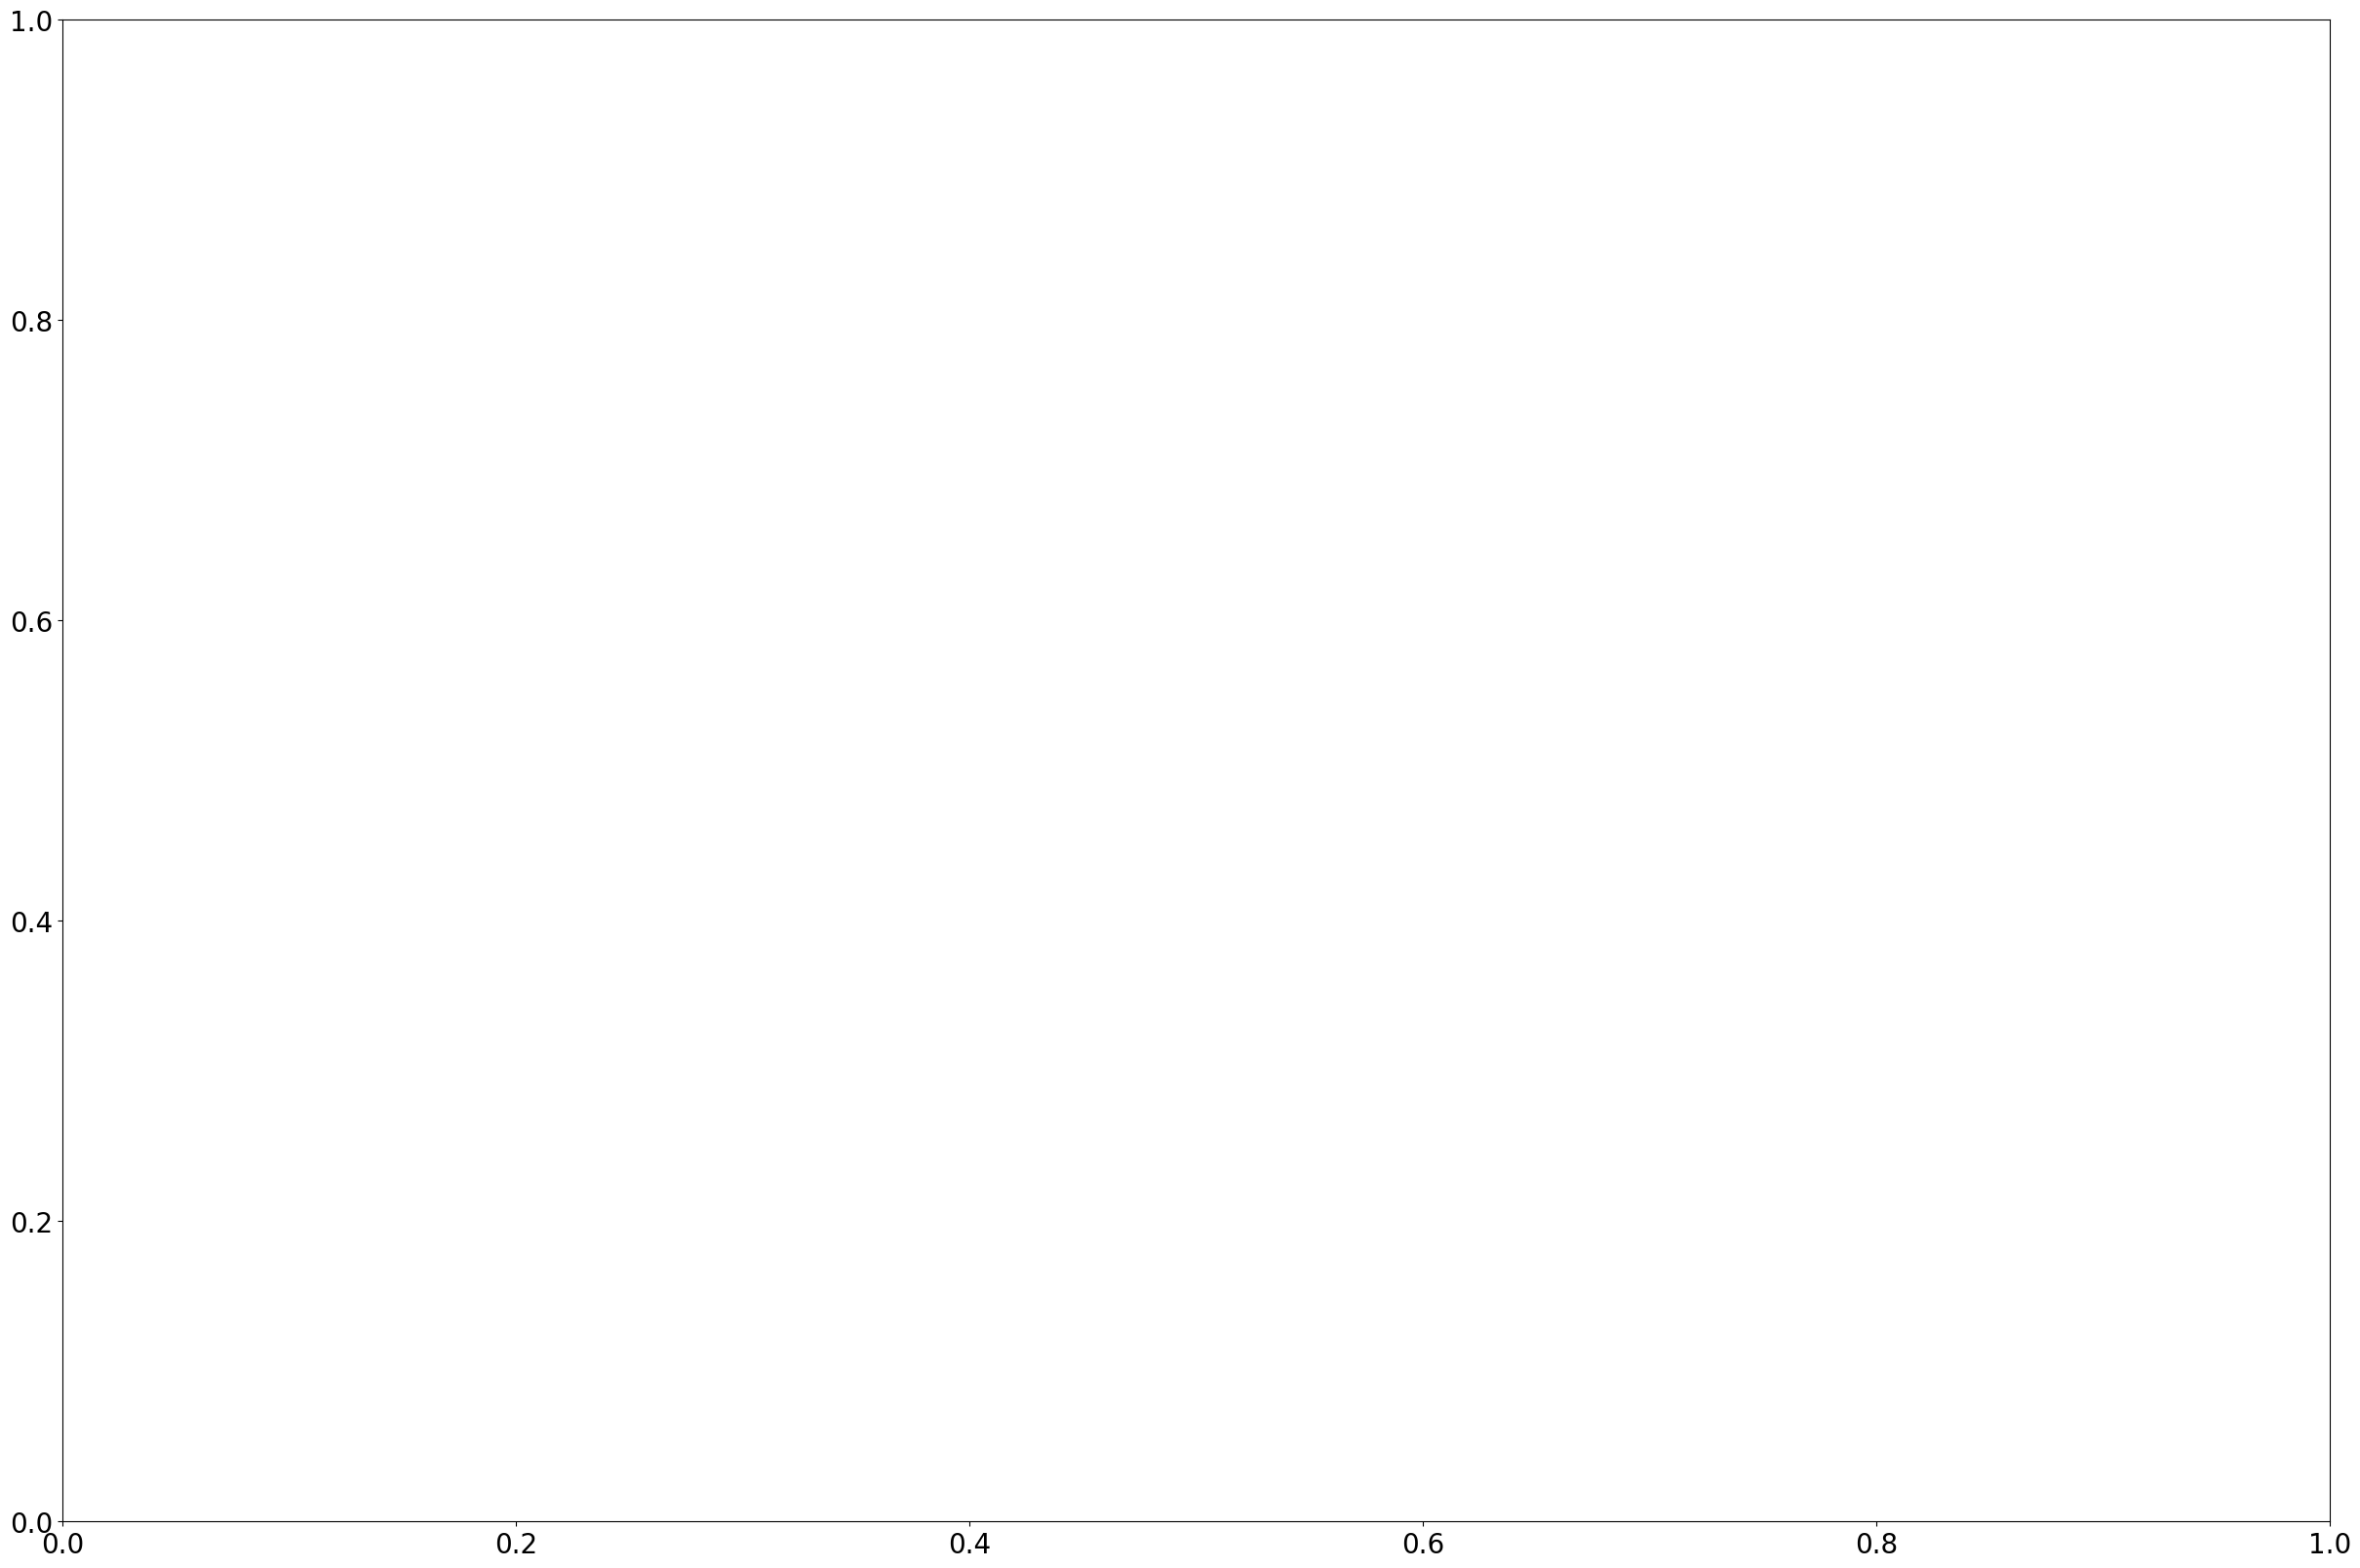

In [24]:
import bootstrap
reps=30
x_c=np.linspace(0,15,num=16)
raw_fidelity_list = eab_result["fidelity_list"]
fig.set_figwidth(30)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=30)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(30,20))
bootstrap_sample_size=[15,17,19]
i=0
for s in bootstrap_sample_size:
    plot_dic={}
    error_dic={}
    # sys.exit(0)
    # depth=[2,4,8,16,32]
    fidelity_list = {}
    stdev_list = {}
    alpha_detail={}
    a_detail={}
    alpha_error_detail={}
    Y_detail={}
    Y_err_detail={}
    a_BS_dic={}
    Y_BS_dic={}
    Yerr_BS_dic={}
    for pauli_label in pauli_request_list:
        if(pauli_label == 'I'*nqubit):
            fidelity_list[pauli_label] = 1.0
            stdev_list[pauli_label] = 0.0
            alpha_detail[pauli_label]=[1.0]*reps
            # alpha_error_detail[pauli_label]=0.0]*10
        else:
            alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],s)
            fidelity_list[pauli_label] = alpha_bootstrap #avg pauli fidelity from fit
            stdev_list[pauli_label] = alpha_err_bootstrap #error on pauli fidelity from fit
            a_BS_dic[pauli_label]=a_rtn_frm_fit
            Y_BS_dic[pauli_label]=Y_rtn_frm_fit
            Yerr_BS_dic[pauli_label]=Yerr_rtn_frm_fit 
            alpha_detail[pauli_label]=alpha_rtn_frm_fit
            alpha_error_detail[pauli_label]=alpha_err_rtn_frm_fit



    plt.plot(x_c+0.2*i,[tuple(alpha_detail[pauli_label]) for pauli_label in pauli_request_list],color=pal[3*i],marker="*",linestyle='None',markersize=15,label='sample size'+str(s))
    i+=1
    # legend_elements = [Line2D([0], [0], marker='*', color=pal[7], label='[2,8]',markerfacecolor=pal[7], markersize=25),
    #                    Line2D([0], [0], marker='*', color=pal[5], label='[2,4,8]',markerfacecolor=pal[5], markersize=25),
    #                    Line2D([0], [0], marker='*', color=pal[3], label='[2,4,8,16]',markerfacecolor=pal[3], markersize=25),
    #                    Line2D([0], [0], marker='*', color=pal[0], label='[2,4,8,16,32]',markerfacecolor=pal[0], markersize=25),
    #                    Line2D([0], [0], marker='*', color=pal[11], label='CB[2,8]',markerfacecolor=pal[11], markersize=25),
    #                    Line2D([0], [0], marker='*', color=pal[15], label='CB[2,8,32]',markerfacecolor=pal[15], markersize=25),
    #                    Line2D([0], [0], marker='*', color=pal[17], label='CB[8,32]',markerfacecolor=pal[17], markersize=25),
                      
    #                   ]
plt.legend()    

# pauli_label="IX"
# print (Y_BS_dic["IX"][0])    
# print (Yerr_BS_dic["IX"][0])  
# print (a_BS_dic["IX"][0])
# print (alpha_detail[pauli_label][0])

In [22]:
import statistics
print (len(alpha_detail["XY"]))
print (statistics.variance(alpha_detail["XX"]))

10
1.6847567504143941e-06


Method I: use the average of the 10 sets of Pauli fidelities from 10 times of resampling in bootstrapping


In [ ]:
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        continue
    else:
        print (pauli_label[::-1],round(1-fidelity_list[pauli_label],7),round(stdev_list[pauli_label],7))


x_c=np.linspace(0,32,num=80)
# nqubit=2
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (4):
    for j in range(4):
        pauli_label=pauli_request_list[4*i+j]
        if (pauli_label == 'I'*nqubit):
#                 fidelity_list[pauli_label] = 1.0
#                 stdev_list[pauli_label] = 0.0
            pass
        else:
            axs[i, j].set_xticks(depth)   
            for m in range (10):
                axs[i, j].errorbar(depth,Y_BS_dic[pauli_label][m], yerr=Yerr_BS_dic[pauli_label][m], fmt='o',markersize=5)
                axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_BS_dic[pauli_label][m], alpha_detail[pauli_label][m]))
            axs[i, j].set_title(pauli_label[::-1])

print (alpha_detail)    

Method II: use the average of the 10 sets of Y from resampling as the a new set of Y and do the fit once with the new Y


In [ ]:
raw_fidelity_list_avg={}
for pauli_label in pauli_request_list:
    raw_fidelity_list_avg[pauli_label]={}
    raw_fidelity_list_avg[pauli_label][2]=[]
    # raw_fidelity_list_avg[pauli_label][4]=[]
    raw_fidelity_list_avg[pauli_label][8]=[]
    raw_fidelity_list_avg[pauli_label][16]=[]
    raw_fidelity_list_avg[pauli_label][32]=[]
    if (pauli_label=="II"):
        raw_fidelity_list_avg[pauli_label][2]=[1.0]*10
        # raw_fidelity_list_avg[pauli_label][4]=[1.0]*10
        raw_fidelity_list_avg[pauli_label][8]=[1.0]*10
        raw_fidelity_list_avg[pauli_label][16]=[1.0]*10
        raw_fidelity_list_avg[pauli_label][32]=[1.0]*10
    else:
        for i in range (10):
            raw_fidelity_list_avg[pauli_label][2].append(Y_BS_dic[pauli_label][i][0])
            # raw_fidelity_list_avg[pauli_label][4].append(Y_BS_dic[pauli_label][i][1])
            raw_fidelity_list_avg[pauli_label][8].append(Y_BS_dic[pauli_label][i][1])
            raw_fidelity_list_avg[pauli_label][16].append(Y_BS_dic[pauli_label][i][2])
            raw_fidelity_list_avg[pauli_label][32].append(Y_BS_dic[pauli_label][i][3])


raw_fidelity_list = raw_fidelity_list_avg
plot_dic={}
error_dic={}
# sys.exit(0)
# depth=[2,4,8,16,32]
fidelity_list = {}
stdev_list = {}
a_full_dic={}
Y_full_dic={}
Yerr_full_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha,a, alpha_err,Y, Yerr = fit_EAB_plot(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha #pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err #error on pauli fidelity from fit
        a_full_dic[pauli_label]=a 
        Y_full_dic[pauli_label]=Y
        Yerr_full_dic[pauli_label]=Yerr

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(1-fidelity_list[pauli_label],7), round(stdev_list[pauli_label],7))
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]


plot_full={}
plot_full=deepcopy(plot_dic)
err_full=deepcopy(error_dic)
print (Y_full_dic)

x_c=np.linspace(0,32,num=80)
nqubit=2
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (4):
    for j in range(4):
        pauli_label=pauli_request_list[4*i+j]
        if (pauli_label == 'I'*nqubit):
            pass
        else:
            axs[i, j].set_xticks(depth)   
            axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=5)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
                
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)  

In [ ]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(error_list[pauli_label],7))


# Bootstrapping for different number of layers
Obtain the lists of:  
    alpha_detail[pauli_label]=alpha_rtn_frm_fit
    alpha_error_detail[pauli_label]=alpha_err_rtn_frm_fit
for different number of layers

plot alpha_detail vs. number of layers

In [ ]:
#####dpth=[2,8]
import bootstrap
raw_fidelity_list = eab_result["fidelity_list"]
depth=[2,8]
fidelity_list = {}
stdev_list = {}
a_detail={}
Y_detail={}
Y_err_detail={}
a_BS_dic={}
Y_BS_dic={}
Yerr_BS_dic={}

alpha_detail_d28={}
alpha_error_detail_d28={}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        alpha_detail_d28[pauli_label] = [1.0]*10
        alpha_error_detail_d28[pauli_label] = [0.0]*10
    else:
        alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],15)
        alpha_detail_d28[pauli_label]=alpha_rtn_frm_fit
        alpha_error_detail_d28[pauli_label]=alpha_err_rtn_frm_fit
# print (alpha_detail_d28)
filename="alpha_detail_d28"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/for plotting/scan wait time test/150us/"+filename, "wb") as fp:
    pickle.dump(alpha_detail_d28, fp)


    #####dpth=[8,32]
raw_fidelity_list = eab_result["fidelity_list"]
depth=[8,32]
fidelity_list = {}
stdev_list = {}
a_detail={}
Y_detail={}
Y_err_detail={}
a_BS_dic={}
Y_BS_dic={}
Yerr_BS_dic={}

alpha_detail_d832={}
alpha_error_detail_d832={}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        alpha_detail_d832[pauli_label] = [1.0]*10
        alpha_error_detail_d832[pauli_label] = [0.0]*10
    else:
        alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],15)
        alpha_detail_d832[pauli_label]=alpha_rtn_frm_fit
        alpha_error_detail_d832[pauli_label]=alpha_err_rtn_frm_fit
# print (alpha_detail_d2)
filename="alpha_detail_d832"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/for plotting/scan wait time test/150us/"+filename, "wb") as fp:
    pickle.dump(alpha_detail_d832, fp)


# ####dpth=[2,4,8]
# raw_fidelity_list = eab_result["fidelity_list"]
# depth=[2,4,8]
# fidelity_list = {}
# stdev_list = {}
# a_detail={}
# Y_detail={}
# Y_err_detail={}
# a_BS_dic={}
# Y_BS_dic={}
# Yerr_BS_dic={}

# alpha_detail_d248={}
# alpha_error_detail_d248={}

# for pauli_label in pauli_request_list:
#     if(pauli_label == 'I'*nqubit):
#         alpha_detail_d248[pauli_label] = [1.0]*10
#         alpha_error_detail_d248[pauli_label] = [0.0]*10
#     else:
#         alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],15)
#         alpha_detail_d248[pauli_label]=alpha_rtn_frm_fit
#         alpha_error_detail_d248[pauli_label]=alpha_err_rtn_frm_fit
# # # print (alpha_detail_2)
# filename="alpha_detail_d248"
# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/for plotting/FT_EAB_scale0_test/"+filename, "wb") as fp:
#     pickle.dump(alpha_detail_d248, fp)

#####dpth=[2,8,32]
raw_fidelity_list = eab_result["fidelity_list"]
depth=[2,8,32]
fidelity_list = {}
stdev_list = {}
a_detail={}
Y_detail={}
Y_err_detail={}
a_BS_dic={}
Y_BS_dic={}
Yerr_BS_dic={}

alpha_detail_d2832={}
alpha_error_detail_d2832={}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        alpha_detail_d2832[pauli_label] = [1.0]*10
        alpha_error_detail_d2832[pauli_label] = [0.0]*10
    else:
        alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],15)
        alpha_detail_d2832[pauli_label]=alpha_rtn_frm_fit
        alpha_error_detail_d2832[pauli_label]=alpha_err_rtn_frm_fit
# print (alpha_detail_2)
filename="alpha_detail_d2832"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/for plotting/scan wait time test/150us/"+filename, "wb") as fp:
    pickle.dump(alpha_detail_d2832, fp)

# ####dpth=[2,4,8,16]
# raw_fidelity_list = eab_result["fidelity_list"]
# depth=[2,4,8,16]
# fidelity_list = {}
# stdev_list = {}
# a_detail={}
# Y_detail={}
# Y_err_detail={}
# a_BS_dic={}
# Y_BS_dic={}
# Yerr_BS_dic={}

# alpha_detail_d24816={}
# alpha_error_detail_d24816={}

# for pauli_label in pauli_request_list:
#     if(pauli_label == 'I'*nqubit):
#         alpha_detail_d24816[pauli_label] = [1.0]*10
#         alpha_error_detail_d24816[pauli_label] = [0.0]*10
#     else:
#         alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],15)
#         alpha_detail_d24816[pauli_label]=alpha_rtn_frm_fit
#         alpha_error_detail_d24816[pauli_label]=alpha_err_rtn_frm_fit
# # # print (alpha_detail_2)
# filename="alpha_detail_d24816"
# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/for plotting/FT_EAB_scale0_test/"+filename, "wb") as fp:
#     pickle.dump(alpha_detail_d24816, fp)
    
# ####depth=[2,4,8,16,32]
# alpha_detail_d2481632={}
# alpha_error_detail_d2481632={}
# alpha_detail_d2481632= alpha_detail
# alpha_error_detail_d2481632=alpha_error_detail
# alpha_detail_d2481632["II"] = [1.0]*10
# alpha_error_detail_d2481632["II"] = [0.0]*10

# filename="alpha_detail_d2481632"
# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/for plotting/FT_EAB_scale0_test/"+filename, "wb") as fp:
#     pickle.dump(alpha_detail_d2481632, fp)

In [ ]:

# raw_fidelity_list = eab_result["fidelity_list"]
# depth=[8,16,32]
# fidelity_list = {}
# stdev_list = {}
# a_detail={}
# Y_detail={}
# Y_err_detail={}
# a_BS_dic={}
# Y_BS_dic={}
# Yerr_BS_dic={}

# alpha_detail_d81632={}
# alpha_error_detail_d81632={}

# for pauli_label in pauli_request_list:
#     if(pauli_label == 'I'*nqubit):
#         alpha_detail_d81632[pauli_label] = [1.0]*10
#         alpha_error_detail_d81632[pauli_label] = [0.0]*10
#     else:
#         alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],15)
#         alpha_detail_d81632[pauli_label]=alpha_rtn_frm_fit
#         alpha_error_detail_d81632[pauli_label]=alpha_err_rtn_frm_fit
# # # print (alpha_detail_2)
# filename="alpha_detail_d81632"
# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/for plotting/FT_EAB_scale0_test/"+filename, "wb") as fp:
#     pickle.dump(alpha_detail_d81632, fp)

In [ ]:
CB_alpha_detail_d28={}
CB_alpha_detail_d2832={}
CB_alpha_detail_d832={}
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/CB_alpha_detail_d2", "rb") as fp:   # Unpickling
    CB_alpha_detail_d28 = pickle.load(fp)
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/CB_alpha_detail_d3", "rb") as fp:   # Unpickling
    CB_alpha_detail_d2832 = pickle.load(fp)
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/CB_alpha_detail_d4", "rb") as fp:   # Unpickling
    CB_alpha_detail_d832 = pickle.load(fp)

In [ ]:
##plot  alpha_detail vs. depth
import seaborn as sns
pal = sns.color_palette("PRGn",20)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# fig, axs = plt.subplots(4, 4)
fig.set_figwidth(30)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
# for i in range (4):
#     for j in range(4):
#         pauli_label=pauli_request_list[4*i+j]
#         if (pauli_label == 'I'*nqubit):
#             pass
#         else:
#             axs[i, j].set_xticks([2,4,8,16,32])   
#             axs[i, j].plot(depth,[tuple(eab_result['fidelity_list'][pauli_label][L]) for L in depth],"*",markersize=3)
# #             axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=5)
# #             axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
#             axs[i, j].set_title(pauli_label[::-1])
plt.figure(figsize=(30,20))
plt.plot(pauli_request_list,[tuple(alpha_detail_d2[pauli_label]) for pauli_label in pauli_request_list],"r*",markersize=15,label='depth 2')
plt.plot(pauli_request_list,[tuple(alpha_detail_d3[pauli_label]) for pauli_label in pauli_request_list],"b*",markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

plt.plot(pauli_request_list,[tuple(alpha_detail_d4[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')
plt.plot(pauli_request_list,[tuple(alpha_detail_d5[pauli_label]) for pauli_label in pauli_request_list],"m*",markersize=15,label='depth 5')
legend_elements = [Line2D([0], [0], marker='*', color='r', label='[2,4]',markerfacecolor='r', markersize=25),
                   Line2D([0], [0], marker='*', color='b', label='[2,4,8]',markerfacecolor='b', markersize=25),
                   Line2D([0], [0], marker='*', color='g', label='[2,4,8,16]',markerfacecolor='g', markersize=25),
                   Line2D([0], [0], marker='*', color='m', label='[2,4,8,16,32]',markerfacecolor='m', markersize=25),
                  ]

# plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d2[pauli_label]) for pauli_label in pauli_request_list],"r*",markersize=15,label='depth 2')
# plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d3[pauli_label]) for pauli_label in pauli_request_list],"b*",markersize=15,label='depth 3')
# # plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

# plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d4[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

plt.legend(handles=legend_elements, loc='upper center',fontsize=25)
# plt.legend()
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)  

# plt.figure(figsize=(30,20))
#  plt.plot(pauli_request_list,[tuple(alpha_detail_d2[pauli_label]) for pauli_label in pauli_request_list],"r*",markersize=15,label='depth 2')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d3[pauli_label]) for pauli_label in pauli_request_list],"b*",markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d4[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d5[pauli_label]) for pauli_label in pauli_request_list],"m*",markersize=15,label='depth 5')
# plt.legend()

In [ ]:
##plot  alpha_detail vs. depth
import seaborn as sns
pal = sns.color_palette("PRGn",20)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# fig, axs = plt.subplots(4, 4)
fig.set_figwidth(30)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=30)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
plt.rcParams.update({'font.size': 20})
# for i in range (4):
#     for j in range(4):
#         pauli_label=pauli_request_list[4*i+j]
#         if (pauli_label == 'I'*nqubit):
#             pass
#         else:
#             axs[i, j].set_xticks([2,4,8,16,32])   
#             axs[i, j].plot(depth,[tuple(eab_result['fidelity_list'][pauli_label][L]) for L in depth],"*",markersize=3)
# #             axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=5)
# #             axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
#             axs[i, j].set_title(pauli_label[::-1])
plt.figure(figsize=(30,20))
plt.plot(pauli_request_list,[tuple(alpha_detail_d2[pauli_label]) for pauli_label in pauli_request_list],color=pal[7],marker="*",linestyle='None',markersize=15,label='depth 2')
plt.plot(pauli_request_list,[tuple(alpha_detail_d3[pauli_label]) for pauli_label in pauli_request_list],color=pal[5],marker="*",linestyle='None',markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

# plt.plot(pauli_request_list,[tuple(alpha_detail_d4[pauli_label]) for pauli_label in pauli_request_list],color=pal[3],marker="*",linestyle='None',markersize=15,label='depth 4')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d5[pauli_label]) for pauli_label in pauli_request_list],color=pal[0],marker="*",linestyle='None',markersize=15,label='depth 5')
plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d28[pauli_label]) for pauli_label in pauli_request_list],color=pal[11],marker="*",linestyle='None',markersize=15,label='depth 2')
plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d2832[pauli_label]) for pauli_label in pauli_request_list],color=pal[15],marker="*",linestyle='None',markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

# plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d832[pauli_label]) for pauli_label in pauli_request_list],color=pal[18],marker="*",linestyle='None',markersize=15,label='depth 4')

# legend_elements = [Line2D([0], [0], marker='*', color=pal[7], label='[2,4]',markerfacecolor=pal[7], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[5], label='[2,4,8]',markerfacecolor=pal[5], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[3], label='[2,4,8,16]',markerfacecolor=pal[3], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[0], label='[2,4,8,16,32]',markerfacecolor=pal[0], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[11], label='CB[2,8]',markerfacecolor=pal[11], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[15], label='CB[2,8,32]',markerfacecolor=pal[15], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[17], label='CB[8,32]',markerfacecolor=pal[17], markersize=25),
                  
                  ]


plt.legend(handles=legend_elements, loc='upper center',fontsize=25)
# plt.leg

In [ ]:
##plot  alpha_detail vs. depth
import seaborn as sns
pal = sns.color_palette("PRGn",20)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# fig, axs = plt.subplots(4, 4)
fig.set_figwidth(30)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=30)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
plt.rcParams.update({'font.size': 20})
# for i in range (4):
#     for j in range(4):
#         pauli_label=pauli_request_list[4*i+j]
#         if (pauli_label == 'I'*nqubit):
#             pass
#         else:
#             axs[i, j].set_xticks([2,4,8,16,32])   
#             axs[i, j].plot(depth,[tuple(eab_result['fidelity_list'][pauli_label][L]) for L in depth],"*",markersize=3)
# #             axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=5)
# #             axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
#             axs[i, j].set_title(pauli_label[::-1])
plt.figure(figsize=(30,20))
plt.plot(pauli_request_list,[tuple(alpha_detail_d2[pauli_label]) for pauli_label in pauli_request_list],color=pal[7],marker="*",linestyle='None',markersize=15,label='depth 2')
plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],color=pal[5],marker="*",linestyle='None',markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

plt.plot(pauli_request_list,[tuple(alpha_detail_d3[pauli_label]) for pauli_label in pauli_request_list],color=pal[3],marker="*",linestyle='None',markersize=15,label='depth 4')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d5[pauli_label]) for pauli_label in pauli_request_list],color=pal[0],marker="*",linestyle='None',markersize=15,label='depth 5')
plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d28[pauli_label]) for pauli_label in pauli_request_list],color=pal[11],marker="*",linestyle='None',markersize=15,label='depth 2')
plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d2832[pauli_label]) for pauli_label in pauli_request_list],color=pal[15],marker="*",linestyle='None',markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d832[pauli_label]) for pauli_label in pauli_request_list],color=pal[18],marker="*",linestyle='None',markersize=15,label='depth 4')

legend_elements = [Line2D([0], [0], marker='*', color=pal[7], label='[2,8]',markerfacecolor=pal[7], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[5], label='[2,4,8]',markerfacecolor=pal[5], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[3], label='[2,4,8,16]',markerfacecolor=pal[3], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[0], label='[2,4,8,16,32]',markerfacecolor=pal[0], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[11], label='CB[2,8]',markerfacecolor=pal[11], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[15], label='CB[2,8,32]',markerfacecolor=pal[15], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[17], label='CB[8,32]',markerfacecolor=pal[17], markersize=25),
                  
                  ]


plt.legend(handles=legend_elements, loc='upper center',fontsize=25)
# plt.leg